# Learning to inditify a some new features to improve myself.
- Refers:  https://tomaugspurger.net/posts/modern-1-intro/
- Rdatasets: https://github.com/vincentarelbundock/Rdatasets/tree/master

# Morden Pandas Part 1

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('T_ONTIME_REPORTING.csv',parse_dates=["FL_DATE"]).rename(columns= str.lower)
df.info()


In [ ]:
df.keys()

###### EXPLICI IS BETTER THAN IMPLICIT

##### Slicing

In [ ]:
# .loc for label-based indexing
# .iloc for positional indexing
first= df.groupby('op_unique_carrier')[['fl_date','air_time']].first()
first.head()

In [ ]:
# slicing take a (0,1) row and two column
first.iloc[[0,1],[0,1]]


In [ ]:
#or
# a index: 19393(row) + column(fl_date,airline_code)
first.loc[['DL','9E'], ['fl_date','air_time']]

##### SettingWithCopy 

In [ ]:
f = pd.DataFrame({'a':[1,2,3,4,5],'b':[10,20,30,40,50]})
f

In [ ]:
f.loc[f['a'] <=3, 'b'] = f.loc[f['a'] <= 3, 'b']/10

f

##### Mutidimensional Indexing

In [ ]:
hdf = df.set_index(['origin', 'dest','fl_date', 'op_unique_carrier']).sort_index()
hdf[hdf.columns[:5]].head(1000)


In [ ]:
hdf.loc[(['ABE', 'ATL'], ['ORD', 'DSM']), ['dep_time', 'dep_delay']]


In [ ]:
hdf.loc[pd.IndexSlice[:, ['ORD', 'DSM']], ['dep_time', 'dep_delay']]
#The : says include every label in this level. The IndexSlice object is just sugar for the actual python slice object needed to remove slice each level.

# Morden Pandas Part 2

##### Method Chaining - Where you call methods on an object one after another

In [112]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='ticks', context='talk')

                 

In [ ]:
def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['op_unique_carrier']),
                    ))
    return df
          
def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city and destiny_city
    '''
    cols = ['origin_city_name','dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*),\w{2}", expand =False))
    df = df.copy()
    df[['origin_city_name','dest_city_name']] = city
    return df

def time_to_datetime(df,columns):
    '''
    combine all time items into datetimes
    2019-01-01,0914 -> 2019-01-01,09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                        .str.replace('\.0$', '')  # NaNs force float dtype
                        .str.pad(4, fillchar='0'))
        return pd.to_datetime(df['fl_date']+' '+ timepart.str.slice(0,2)+ ':'+ timepart.str.slice(2,4),errors='coerce')
    df[columns] = df[columns].apply(converter)
    return df

output = 'T_ONTIME_REPORTING.csv'

if not os.path.exists(output):
    print('downloading data')
else:
    df = read(output)
df.info()

C:\Users\Luis\AppData\Local\Temp\ipykernel_16784\4262093795.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(df['fl_date']+' '+ timepart.str.slice(0,2)+ ':'+ timepart.str.slice(2,4),errors='coerce')


##### Some way to apply a chain method

In [ ]:
#Anolagy
jack_jill = pd.DataFrame()
(jack_jill.pipe(went_up, 'hill')
    .pipe(fetch, 'water')
    .pipe(fell_down, 'jack')
    .pipe(broke, 'crown')
    .pipe(tumble_after, 'jill')
)

##### Costs

One drawback to excessively long chains is that debugging can be harder.
For large workflows, you’ll probably want to move away from pandas to something more structured, like Airflow or Luigi.

In [8]:
#When writing medium sized ETL jobs in python that will be run repeatedly, I’ll use decorators to inspect and log properties about the DataFrames at each step of the process.

from functools import wraps
import logging

def log_shape(func):
    @wraps(func)
    def wrapper(*args,**kwargs):
        result = func(*args,**kwargs)
        logging.info("%s,$s" % (func.__name__,result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args,**kwargs):
        result = func(*args,**kwargs)
        logging.info("%s,$s" % (func.__name__,result.dtypes))
        return result
    return wrapper

@log_dtypes
@log_shape
def load(fp):
    df = pd.read_csv(output,index_col=0,parse_dates=True)
    
@log_dtypes
@log_shape
def updatte_events(df,new_events):
    df.loc[new_events.index,'foo']= new_events
    return df

##### Inplace

Most pandas methods have an inplace keyword that’s False by default. In general, you shouldn’t do inplace operations.

That is, the pandas code might look something like this

In [ ]:
def dataframe_method(self, inplace=False):
    data = self.copy()  # regardless of inplace
    result = ...
    if inplace:
        self._update_inplace(data)
    else:
        return result


There’s a lot of defensive copying in pandas. Part of this comes down to pandas being built on top of NumPy, and not having full control over how memory is handled and shared. 

##### Application

What does the daily flight pattern look like?

In [ ]:
(df.dropna(subset=['dep_time', 'op_unique_carrier'])
   .loc[df['op_unique_carrier']
       .isin(df['op_unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   # TimeGrouper to resample & groupby at once
   .groupby(['op_unique_carrier', pd.Grouper(freq="H")])
   .size()
   .unstack(0)
   .fillna(0)
   .rolling(24)
   .sum()
   .rename_axis("Flights per Day", axis=1)
   .plot()
)
sns.despine()

In [59]:
import statsmodels.api as sm


Does a plane with multiple flights on the same day get backed up, causing later flights to be delayed more?

In [ ]:
%config InlineBackend.figure_format = 'png'
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
           .dropna()
           .sort_values('dep_time')
           .loc[lambda x: x.dep_delay < 500]
           .assign(turn = lambda x:
                x.groupby(['fl_date', 'tail_num'])
                 .dep_time
                 .transform('rank').astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax,palette=sns.color_palette("husl", 8))
ax.set_ylim(-50, 50)
sns.despine()



Do flights later in the day have longer delays?

In [ ]:
plt.figure(figsize=(15, 5))
(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe(sns.boxplot, x='hour', y='dep_delay', showmeans=True))
sns.despine()


# Morden Pandas Part 3 

#### Indexes

##### *offers*


- metadata container
- easy label-based row selection
- ease label-based alignment in operations
- label-based concatenation

In [61]:
a=pd.Index([1,2,3])
a

Index([1, 2, 3], dtype='int64')

In [62]:
s = pd.Series([1, 2, 3], index=['a', 'b', None])
s

a       1
b       2
None    3
dtype: int64

##### Set Operations

Indexes are set-like(multisets,since you can have duplicates).
- Are immutable, so you won't find any of the inplace
- One other difference is that since Indexes are also array like, you can’t use some infix operators like - for difference.
- If you have a numeric index it is unclear whether you intend to perform math operations or set operations.
- You can use & for intersetion, | for union, and ^ for symmetric difference though, since there’s no ambiguity.

##### Flavors

Pandas has many7 subclasse of the regular index
- index
- int64Index
- RangeIndex( memory-saving speciall case of int64Index)
- FloatIndex
- DatetimeIndex ( DateTime64[ns] precision data)
- PeriodIndex
- TTimedeltaIndex
- CategoricalIndex

##### Row Slicing

In [95]:
# great to makeing row subsetting as easy as column substting.
s.loc['a']

1

In [ ]:
s.reset_index()
s[s[2]== 3]
# without index we'd probably resort to boolean masks

##### Indexes for Easis Arithmetic, Analysis

In [15]:
import pandas as pd
ser_1 = pd.Series([1,2,3,4], index=['a', 'b', 'c', 'd'])
ser_2 = pd.Series([10,20,30,40], index=['a', 'b', 'c', 'd'])
print(ser_1,'\n\n', ser_2)

a    1
b    2
c    3
d    4
dtype: int64 

 a    10
b    20
c    30
d    40
dtype: int64


In [5]:
ser_1 + ser_2

a    11
b    22
c    33
d    44
dtype: int64

##### Indexes for Alignment

Automatic alignment, or reindexing, is fundamental to pandas.

In [39]:
import pandas as pd
import numpy as np
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
index

MultiIndex([('bar', 'one'),
            ('bar', 'two'),
            ('baz', 'one'),
            ('baz', 'two'),
            ('foo', 'one'),
            ('foo', 'two'),
            ('qux', 'one'),
            ('qux', 'two')],
           names=['first', 'second'])

In [35]:
s = pd.Series(np.random.rand(8), index=index)
s

first  second
bar    one       0.667960
       two       0.057380
baz    one       0.421367
       two       0.293868
foo    one       0.963597
       two       0.798238
qux    one       0.590313
       two       0.645839
dtype: float64

In [46]:
print(index.get_level_values(0),'\n',
index.get_level_values("second"))



Index(['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'], dtype='object', name='first') 
 Index(['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two'], dtype='object', name='second')


In [59]:
number_10 = s + 10 /10
number_10

first  second
bar    one       1.667960
       two       1.057380
baz    one       1.421367
       two       1.293868
foo    one       1.963597
       two       1.798238
qux    one       1.590313
       two       1.645839
dtype: float64

##### Merging

**Two ways of merging**
- Relational DataBase style with pd.merge
- Array style with pd.concat

In [114]:
d2 = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d2)



In [125]:
d1 = {'col3': [2, 2], 'col4': [3, 6]}
df2 = pd.DataFrame(data=d1)
df2

,col3,col4
0,2,3
1,2,6


Concat version

In [119]:
# axis = 0 vertically
# axis = 1 horizontally
pd.concat([df,df2],axis=0,join='outer')

,col1,col2
0,1,3
1,2,4
0,2,3
1,2,6


Merge version

In [133]:
pd.merge(df,df2, left_index=True,right_index=True,how='inner').head()

,col1,col2,col3,col4
0,1,3,2,3
1,2,4,2,6


# Morden Pandas Part 4

##### Constructors

Bunch of CSVs that need to be combined into a single DataFrame. Two routes to the same end:
- 1- Initilize one DataFrame and append to that
- 2- Make many smaller DataFrames and concatenate at the end

    - second option is faster

In [ ]:
# If you need to concatenate several dataframes, you don't need to initialize an empty dataframe and append. What can be done is in a pandorable way, use list-comprehension
files = glob.glob('....')
concatdfs = [pd.read_csv(archive) for archive in files]
df = pd.concat(concatdfs)

**Two functions for building an identical DataFrame**

In [1]:
import time
import pandas as pd
import numpy as np

size_per = 5000
N = 100
cols = list('abcd')

def timed(n=30):
    '''
    Running a microbenchmark. Never use this.
    '''
    def deco(func):
        def wrapper(*args, **kwargs):
            timings = []
            for i in range(n):
                t0 = time.time()
                func(*args, **kwargs)
                t1 = time.time()
                timings.append(t1 - t0)
            return timings
        return wrapper
    return deco
    
@timed(60)
def append_df():
    '''
    The pythonic (bad) way
    '''
    df = pd.DataFrame(columns=cols)
    for _ in range(N):
        df = pd.concat([df, pd.DataFrame(np.random.randn(size_per, 4), columns=cols)], ignore_index=True)
    return df

@timed(60)
def concat_df():
    '''
    The pandorabe (good) way
    '''
    dfs = [pd.DataFrame(np.random.randn(size_per, 4), columns=cols)
           for _ in range(N)]
    return pd.concat(dfs, ignore_index=True).dropna(how='all')
t_append = append_df()
t_concat = concat_df()

timings = (pd.DataFrame({"Append": t_append, "Concat": t_concat})
             .stack()
             .reset_index()
             .rename(columns={0: 'Time (s)',
                              'level_1': 'Method'}))
timings.head()


C:\Users\Luis\AppData\Local\Temp\ipykernel_23776\69708688.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(np.random.randn(size_per, 4), columns=cols)], ignore_index=True)
C:\Users\Luis\AppData\Local\Temp\ipykernel_23776\69708688.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(np.random.randn(size_per, 4), columns=cols)], ignore_index=True)
C:\Users\Luis\AppData\Local\Temp\ipykernel_23776\69708688.py:32: FutureWarning: Th

,level_0,Method,Time (s)
0,0,Append,0.171050
1,0,Concat,0.064003
2,1,Append,0.170516
3,1,Concat,0.060512
4,2,Append,0.161029


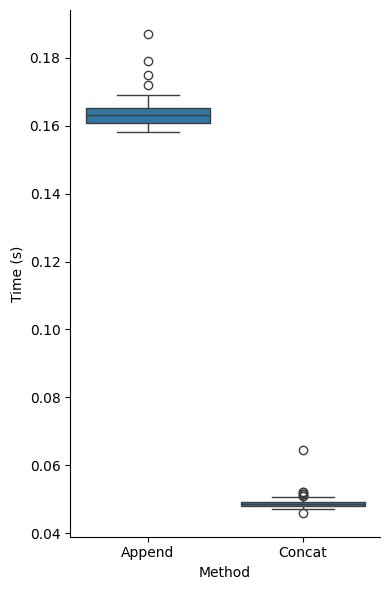

In [11]:
plt.figure(figsize=(4, 6))
sns.boxplot(x='Method', y='Time (s)', data=timings)
sns.despine()
plt.tight_layout()

##### Datatypes

Each column should have a specific dtype; you don’t want to be mixing bools with ints with strings within a single column.

When should you have object columns?

here are a few places where the NumPy / pandas type system isn’t as rich as you might like. There’s no integer NA (at the moment anyway), so if you have any missing values, represented by NaN, your otherwise integer column will be floats. There’s also no date dtype (distinct from datetime). Consider the needs of your application: can you treat an integer 1 as 1.0? Can you treat date(2016, 1, 1) as datetime(2016, 1, 1, 0, 0)?

The last case of object dtype data is text data.
If you have object data (either strings or python objects) that needs to be converted, checkout the to_numeric, to_datetime and to_timedelta methods.

##### Iteration, Apply, And Vectorization

First,benchmark your code.
```
MANY OPTIONS TO BENCHMARK YOUR CODE
https://docs.python.org/3.5/library/timeit.html
https://jiffyclub.github.io/snakeviz/
https://github.com/nvdv/vprof
https://github.com/rkern/line_profiler
```

Second, consider your algorithm.

In [ ]:
df = pd.read_csv("T_ONTIME_REPORTING.csv")
delays = df['DEP_DELAY']
delays.nlargest(5).sort_values()
%timeit delays.nlargest(5).sort_values()
%timeit delays.sort_values().tail(5)

13.8 ms ± 82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.4 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
delays.nsmallest(5).sort_values()

13.9 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### Assuming you’re at a spot that needs optimizing, and you’ve got the correct algorithm, and there isn’t a readily available optimized version of what you need in pandas/numpy/scipy/scikit-learn/statsmodels/…, then what?

The first place to turn is probably a vectorized NumPy implementation. Vectorization here means operating directly on arrays, rather than looping over lists scalars.

= Example calculating the Great-circle distance between airports

In [12]:
coord = (pd.read_csv("T_MASTER_CORD.csv", index_col=['AIRPORT'],
                     usecols=['AIRPORT', 'LATITUDE', 'LONGITUDE'])
           .groupby(level=0).first()
           .dropna()
           .sample(n=500, random_state=42)
           .sort_index())

coord.head()

,LATITUDE,LONGITUDE
AIRPORT,,
1NJ,41.008611,-74.738056
1VA,38.586389,-77.710556
2NY,40.827500,-73.716944
2WK,47.347500,-118.677222
4CA,38.531389,-121.786389


In [ ]:
#MultiIndexes have an alternative from_product constructor for getting the Cartesian product of the arrays you pass in.
# We’ll give it coords.index twice (to get its Cartesian product with itself). 
# That gives a MultiIndex of all the combination. With some minor reshaping of coords we’ll have a DataFrame with all the latitude/longitude pairs.

In [13]:
idx = pd.MultiIndex.from_product([coord.index, coord.index],
                                 names=['origin', 'dest'])

pairs = pd.concat([coord.add_suffix('_1').reindex(idx, level='origin'),
                   coord.add_suffix('_2').reindex(idx, level='dest')],
                  axis=1)
pairs.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_2  LONGITUDE_2
origin dest                                                  
1NJ    1NJ    41.008611   -74.738056   41.008611   -74.738056
       1VA    41.008611   -74.738056   38.586389   -77.710556
       2NY    41.008611   -74.738056   40.827500   -73.716944
       2WK    41.008611   -74.738056   47.347500  -118.677222
       4CA    41.008611   -74.738056   38.531389  -121.786389

In [14]:
idx = idx[idx.get_level_values(0) <= idx.get_level_values(1)]
len(idx)

125250

In [19]:
coord.rename(columns=lambda x: x + '_1')

,LATITUDE_1,LONGITUDE_1
AIRPORT,,
1NJ,41.008611,-74.738056
1VA,38.586389,-77.710556
2NY,40.827500,-73.716944
2WK,47.347500,-118.677222
4CA,38.531389,-121.786389
...,...,...
ZMD,-9.071389,-68.654722
ZOF,52.366667,-127.700000
ZRH,47.458333,8.551667


In [21]:
coord.reindex(idx, level='dest').head()


LATITUDE   LONGITUDE
origin dest                       
1NJ    1NJ   41.008611  -74.738056
       1VA   38.586389  -77.710556
       2NY   40.827500  -73.716944
       2WK   47.347500 -118.677222
       4CA   38.531389 -121.786389

In [22]:
from itertools import product, chain
coord2 = coord.reset_index()
x = product(coord2.add_suffix('_1').itertuples(index=False),
            coord2.add_suffix('_2').itertuples(index=False))
y = [list(chain.from_iterable(z)) for z in x]

df2 = (pd.DataFrame(y, columns=['origin', 'LATITUDE_1', 'LONGITUDE_1',
                                'dest', 'LATITUDE_1', 'LONGITUDE_2'])
       .set_index(['origin', 'dest']))
df2.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_1  LONGITUDE_2
origin dest                                                  
1NJ    1NJ    41.008611   -74.738056   41.008611   -74.738056
       1VA    41.008611   -74.738056   38.586389   -77.710556
       2NY    41.008611   -74.738056   40.827500   -73.716944
       2WK    41.008611   -74.738056   47.347500  -118.677222
       4CA    41.008611   -74.738056   38.531389  -121.786389

In [26]:
import math

def gcd_py(lat1, lng1, lat2, lng2):
    '''
    Calculate great circle distance between two points.
    http://www.johndcook.com/blog/python_longitude_latitude/
    
    Parameters
    ----------
    lat1, lng1, lat2, lng2: float
    
    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    '''
    # python2 users will have to use ascii identifiers (or upgrade)
    degrees_to_radians = math.pi / 180.0
    ϕ1 = (90 - lat1) * degrees_to_radians
    ϕ2 = (90 - lat2) * degrees_to_radians
    
    θ1 = lng1 * degrees_to_radians
    θ2 = lng2 * degrees_to_radians
    
    cos = (math.sin(ϕ1) * math.sin(ϕ2) * math.cos(θ1 - θ2) +
           math.cos(ϕ1) * math.cos(ϕ2))
    # round to avoid precision issues on identical points causing ValueErrors
    cos = round(cos, 8)
    arc = math.acos(cos)
    return arc * 6373  # radius of earth, in kilometers
def gcd_vec(lat1, lng1, lat2, lng2):
    '''
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/
    
    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float
    
    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    '''
    # python2 users will have to use ascii identifiers
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)
    
    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)
    
    cos = (np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) +
           np.cos(ϕ1) * np.cos(ϕ2))
    arc = np.arccos(cos)
    return arc * 6373

In [27]:
%%time
pd.Series([gcd_py(*x) for x in pairs.itertuples(index=False)],
          index=pairs.index)

CPU times: total: 484 ms
Wall time: 430 ms


origin  dest
1NJ     1NJ         0.000000
        1VA       370.247124
        2NY        88.155673
        2WK      3526.541500
        4CA      3982.914226
                    ...     
ZXJ     ZMD      9255.872138
        ZOF       460.935787
        ZRH      8002.640965
        ZVA     16020.828527
        ZXJ         0.000000
Length: 250000, dtype: float64

In [28]:
%%time
r = pairs.apply(lambda x: gcd_py(x['LATITUDE_1'], x['LONGITUDE_1'],
                                 x['LATITUDE_2'], x['LONGITUDE_2']), axis=1);

CPU times: total: 2.53 s
Wall time: 2.26 s


##### Categoricals

 - Are a efficient way to representing data (typically strings) that have a low cardinalit, i.e. relatively few distinct values relative to the size of array.
 - Categorical stores the categories once, and an array of codesm witch are just integers that indicate which category belongs there.

In [29]:
import string

s = pd.Series(np.random.choice(list(string.ascii_letters),100000))
print('{:0.2f} KB'.format(s.memory_usage(index=False)/1000))

800.00 KB


In [30]:
c = s.astype('category')
print('{:0.2f} KB'.format(c.memory_usage(index=False) / 1000))

102.52 KB


```
https://matthewrocklin.com/blog/work/2015/06/18/Categoricals to optimization
```

In [75]:
df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'Danielle'],
                  'balance': [100.0, 200.0, 300.0, 400.0],
                 'gender': ['Female', 'Male', 'Male', 'Female']},
                columns=['name', 'balance', 'gender'])
df.dtypes
# Oh no!  Slow object dtypes!


name        object
balance    float64
gender      object
dtype: object

This integer array is more compact and is now a normal C array. This allows for normal C-speeds on previously slow object dtype columns. Categorizing a column is easy:

In [ ]:
df['gender'] = df['gender'].astype('category')  # Categorize!

In [73]:
# Way to do a category index
df.gender.cat.categories

Index(['Female', 'Male'], dtype='object')

In [74]:
# Numerical values
df.gender.cat.codes 

0    0
1    1
2    1
3    0
dtype: int8

Pandas Categoricals efficiently encode repetitive text data. Categoricals are useful for data like stock symbols, gender, experiment outcomes, cities, states, etc.. Categoricals are easy to use and greatly improve performance on this data.

# Morden Pandas Part 5

In [24]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN PANDAS", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set_theme(style='ticks', context='talk')

In [25]:
fp = 'nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,LOG,Arena,Notes
0,0,"Tue, Oct 27, 2015",8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,2:22,United Center,NaN
1,1,"Tue, Oct 27, 2015",8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,2:10,Philips Arena,NaN
2,2,"Tue, Oct 27, 2015",10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,2:24,Oracle Arena,NaN
3,3,"Wed, Oct 28, 2015",7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,2:21,Amway Center,NaN
4,4,"Wed, Oct 28, 2015",7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,2:13,TD Garden,NaN


##### How many days of rest did each team get between each game?

In [26]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112


In [27]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Cleveland Cavaliers
1,1,2015-10-27,away_team,Detroit Pistons
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Washington Wizards
4,4,2015-10-28,away_team,Philadelphia 76ers


 Now the translation from question (“How many days of rest between games”) to operation (“date of today’s game - date of previous game - 1”) is direct:

In [28]:
tidy.groupby('team')['date'].diff().dt.days -1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    0.0
72    2.0
73    2.0
74    2.0
75    1.0
Name: date, Length: 76, dtype: float64

In [29]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
5,5,2015-10-28,away_team,Chicago Bulls,0.0
11,11,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Atlanta Hawks,1.0


In [30]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0


what was each team’s average days of rest, at home and on the road?

In [44]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0,True,0.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0,False,0.0


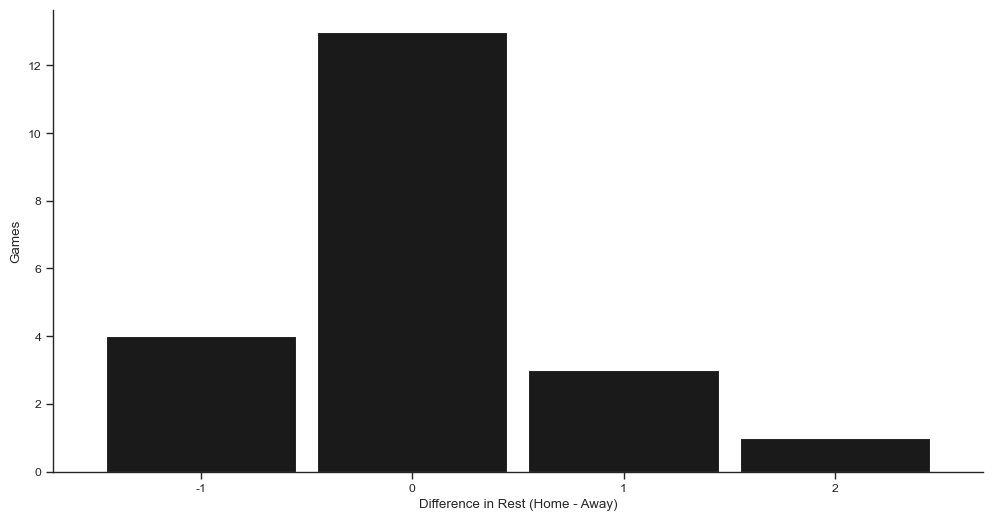

In [45]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

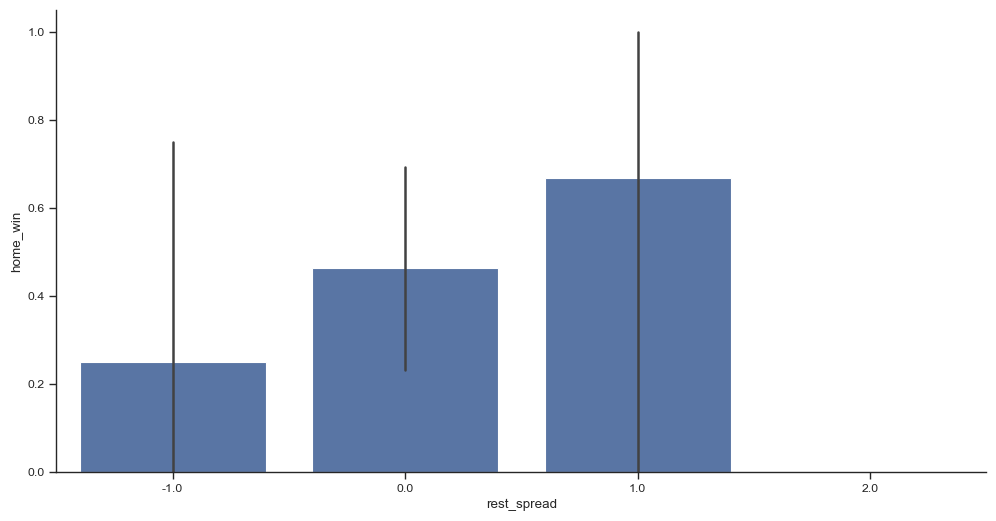

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

##### Stack/Unstack

Pandas has two useful methods for quickly converting from wide to long format (stack) and long to wide (unstack).

- Stack - Return a reshaped DataFrame or Series having a multi-level index with one or more new inner-most levels compared to the current DataFrame.
  - if the columns have a single level, the output is a Series;
  - if the columns have multiple levels, the new index level(s) is (are) taken from the prescribed level(s) and the output is a DataFrame.

In [65]:
df_single_level_cols = pd.DataFrame([[0, 1], [2, 3]],
                                    index=['cat', 'dog'],
                                    columns=['weight', 'height'])
df_single_level_cols

,weight,height
cat,0,1
dog,2,3


In [74]:
df_single_level_cols.stack(future_stack=True)

cat  weight    0
     height    1
dog  weight    2
     height    3
dtype: int64

- Unstack - Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.

In [58]:
index = pd.MultiIndex.from_tuples([('one', 'a'), ('one', 'b'),
                                   ('two', 'a'), ('two', 'b')])
s = pd.Series(np.arange(1.0, 5.0), index=index)
s

one  a    1.0
     b    2.0
two  a    3.0
     b    4.0
dtype: float64

In [62]:
s.unstack(level=0)

,one,two
a,1.0,3.0
b,2.0,4.0


In [63]:
s.unstack(level=0)

,one,two
a,1.0,3.0
b,2.0,4.0


In [47]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

In [48]:
rest.unstack().head()


variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


In [50]:
rest.unstack().stack()


date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

##### Home court advantage?

In [75]:
df['home_win'] = df.home_points > df.away_points


Find the win percent for each team

In [78]:
wins = (
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
   .rename(columns=dict(sum='n_wins',
                        count='n_games',
                        mean='win_pct'))
)
wins.head()

n_wins  n_games  win_pct
team           is_home                            
Atlanta Hawks  away_team       1        1      1.0
               home_team       1        2      0.5
Boston Celtics home_team       1        2      0.5
Brooklyn Nets  away_team       0        2      0.0
               home_team       0        1      0.0

c:\Users\Luis\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


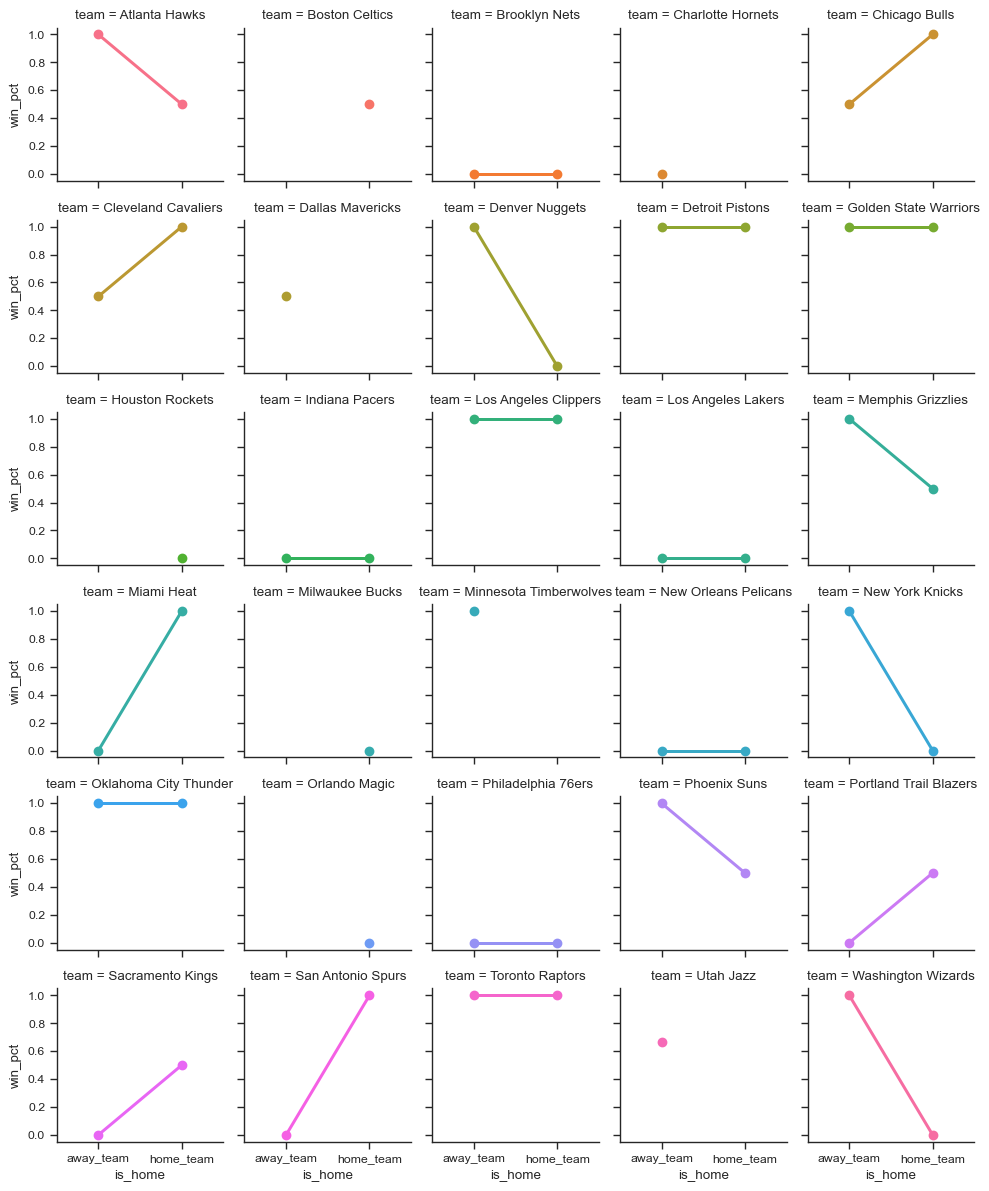

In [86]:
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, height=2)
g.map(sns.pointplot, 'is_home', 'win_pct')

In [87]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level='team', as_index=True)
        .apply(lambda x: x.n_wins.sum() / x.n_games.sum())
)
win_percent.head()

team
Atlanta Hawks        0.666667
Boston Celtics       0.500000
Brooklyn Nets        0.000000
Charlotte Hornets    0.000000
Chicago Bulls        0.666667
dtype: float64

Text(0.5, 104.91666666666664, 'Win Percent')

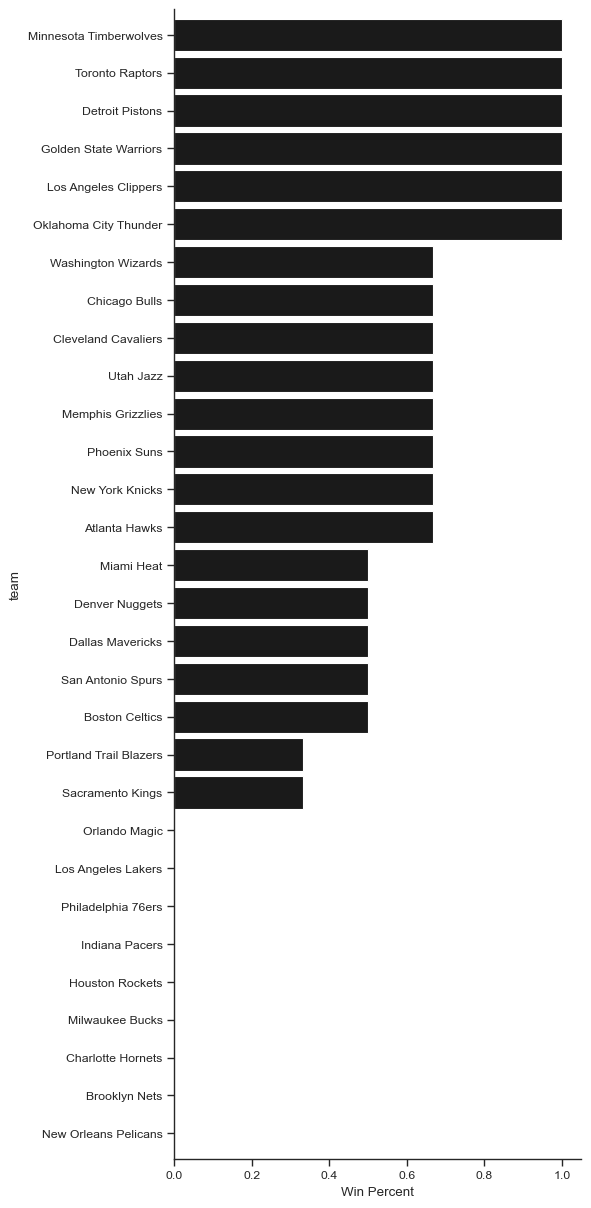

In [88]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=.85, color='k')
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

Is there a relationship between overall team strength and their home-court advantage?

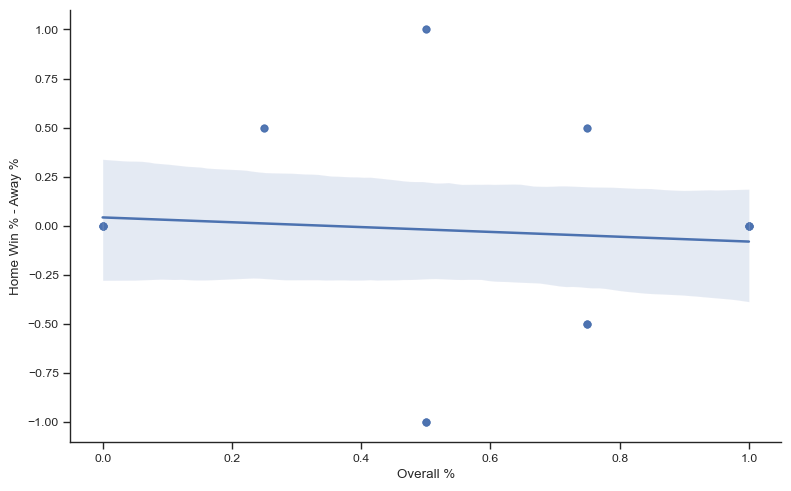

In [89]:
plt.figure(figsize=(8, 5))
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     .pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)
sns.despine()
plt.tight_layout()

In [93]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
               home_strength=df['home_team'].map(win_percent),
               point_diff=df['home_points'] - df['away_points'],
               rest_diff=df['home_rest'] - df['away_rest'])
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,1,NaN,0.666667,0.666667,2,NaN
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,0,NaN,1.000000,0.666667,-12,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,1,NaN,0.000000,1.000000,16,NaN
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,NaN,NaN,0,NaN,0.666667,0.000000,-1,NaN
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,1,NaN,0.000000,0.500000,17,NaN


In [94]:
import statsmodels.formula.api as sm

df['home_win'] = df.home_win.astype(int)  # for statsmodels

# Modern Pandas Part 6

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('diamonds.csv')
df.head()

,rownames,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  53940 non-null  int64  
 1   carat     53940 non-null  float64
 2   cut       53940 non-null  object 
 3   color     53940 non-null  object 
 4   clarity   53940 non-null  object 
 5   depth     53940 non-null  float64
 6   table     53940 non-null  float64
 7   price     53940 non-null  int64  
 8   x         53940 non-null  float64
 9   y         53940 non-null  float64
 10  z         53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [105]:
sns.set_theme(context='talk', style='ticks')

%matplotlib inline

Matiplotlib

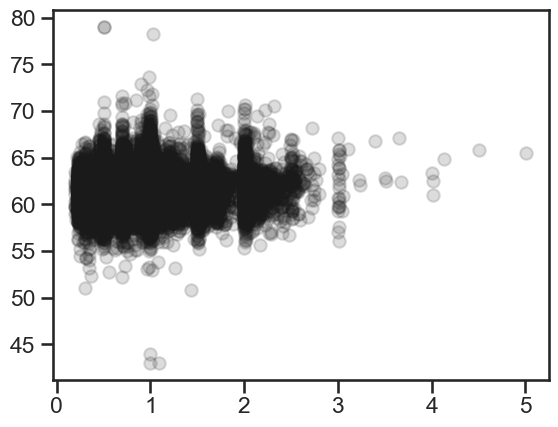

In [106]:
fig, ax = plt.subplots()

ax.scatter(x='carat', y='depth', data=df, c='k', alpha=.15);

Pandas Built-in Plotting

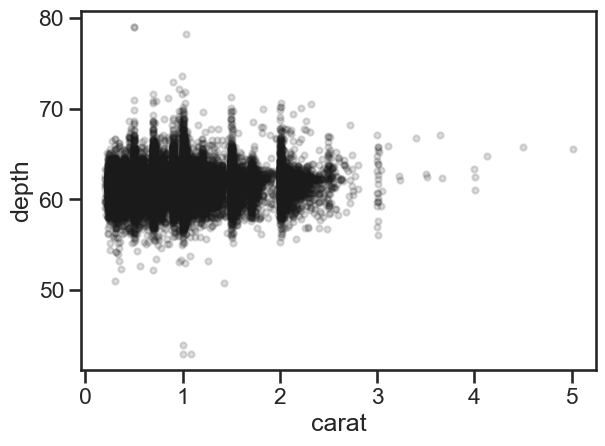

In [107]:
df.plot.scatter(x='carat', y='depth', c='k', alpha=.15)
plt.tight_layout()

## [Seaborn](https://seaborn.pydata.org/tutorial/introduction)

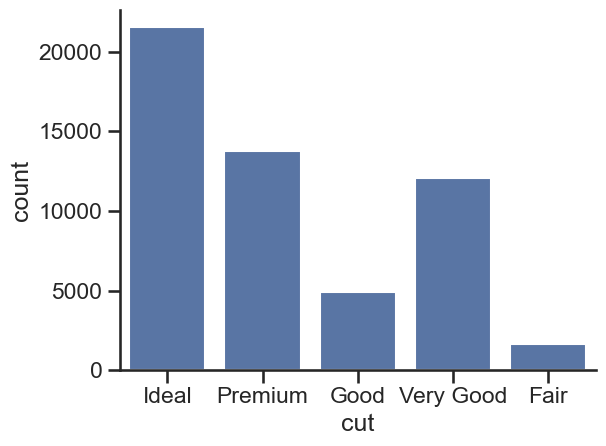

In [110]:
sns.countplot(x='cut', data=df)
sns.despine()
plt.tight_layout()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
df = sns.load_dataset('titanic')

clf = RandomForestClassifier()
param_grid = dict(max_depth=[1, 2, 5, 10, 20, 30, 40],
                  min_samples_split=[2, 5, 10],
                  min_samples_leaf=[2, 3, 5])
est = GridSearchCV(clf, param_grid=param_grid, n_jobs=4)

y = df['survived']
X = df.drop(['survived', 'who', 'alive'], axis=1)

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(value=X.median())
est.fit(X, y);

In [11]:
scores = pd.DataFrame(est.cv_results_)
scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106439,0.004239,0.007251,0.000805,1,2,2,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.743017,0.797753,0.808989,0.741573,0.786517,0.775570,0.028086,62
1,0.106738,0.006253,0.007525,0.001348,1,2,5,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.731844,0.792135,0.814607,0.780899,0.780899,0.780077,0.027076,60
2,0.100931,0.004510,0.006866,0.000421,1,2,10,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.754190,0.792135,0.814607,0.797753,0.820225,0.795782,0.023233,55
3,0.104340,0.006729,0.007167,0.000555,1,3,2,"{'max_depth': 1, 'min_samples_leaf': 3, 'min_s...",0.754190,0.808989,0.820225,0.741573,0.786517,0.782299,0.030388,59
4,0.105488,0.008626,0.006425,0.000743,1,3,5,"{'max_depth': 1, 'min_samples_leaf': 3, 'min_s...",0.793296,0.792135,0.825843,0.780899,0.820225,0.802479,0.017423,53


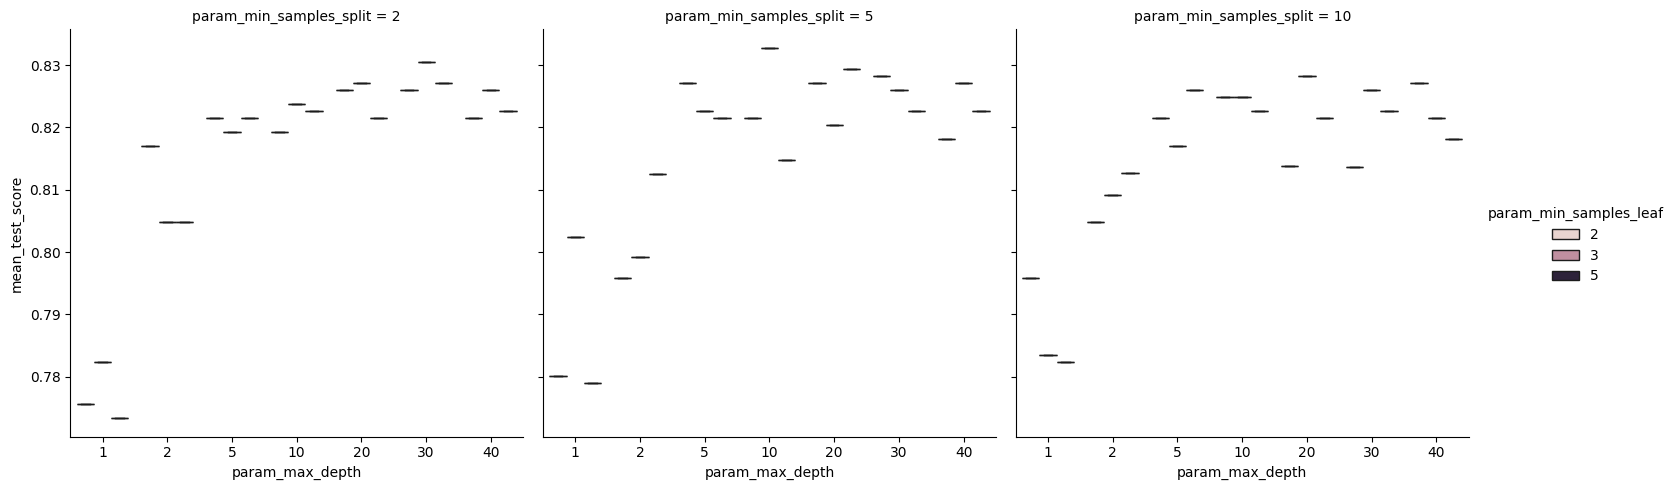

In [14]:
sns.catplot(x='param_max_depth', y='mean_test_score',
            col='param_min_samples_split',
            hue='param_min_samples_leaf',
            data=scores, kind='box')